In [ ]:
# default_exp processing

In [ ]:
from knowledge_distillation import io

In [ ]:
from pandas.api.types import is_numeric_dtype

from knowledge_distillation.ensemble import *

In [ ]:
# export
import numpy as np
from numpy.testing import assert_array_equal
import pandas as pd
from sklearn.ensemble import StackingClassifier
from sklearn.dummy import DummyClassifier
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, f1_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

from category_encoders import OneHotEncoder, OrdinalEncoder
from sklearn_pandas import DataFrameMapper, gen_features
from fastai.tabular.all import *

from knowledge_distillation.io import *

/home/jupyterlab/ni-workspace/conda/envs/kd/lib/python3.8/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /opt/conda/conda-bld/pytorch_1607370172916/work/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


# Load data

In [ ]:
df = load_adult()
assert df.shape == (32561, 15)

In [ ]:
df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,salary
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


# Quick and dirty

In [ ]:
df.salary.value_counts(dropna=False)

 <=50K    24720
 >50K      7841
Name: salary, dtype: int64

In [ ]:
df_code = df.assign(salary = lambda x: x.salary == ' >50K')

## capital-gain

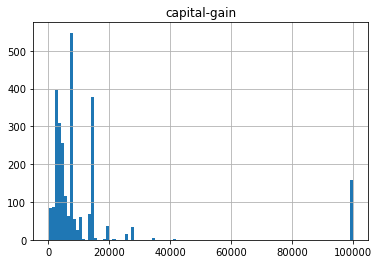

In [ ]:
df_code[df_code['capital-gain'] != 0]['capital-gain'].hist(bins=100)
plt.title('capital-gain');

In [ ]:
df_code['capital-gain']

0         2174
1            0
2            0
3            0
4            0
         ...  
32556        0
32557        0
32558        0
32559        0
32560    15024
Name: capital-gain, Length: 32561, dtype: int64

In [ ]:
cgain_binned = pd.cut(df_code['capital-gain'], bins=[0, 1, 5_000, 10_000, 20_000, float('inf')], include_lowest=True)

<AxesSubplot:xlabel='capital-gain'>

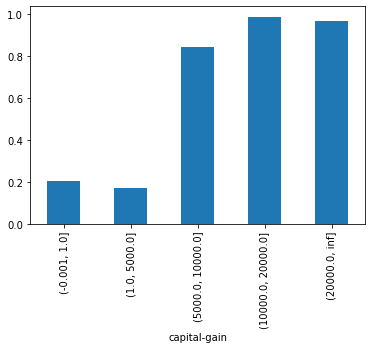

In [ ]:
df_code.groupby(cgain_binned).salary.mean().plot.bar()
# plt.title('salary by capital gain');

## capital loss

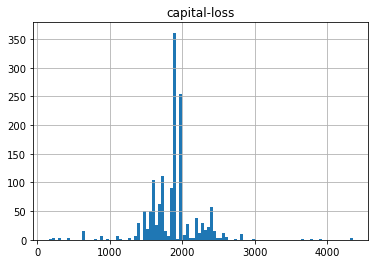

In [ ]:
df_code[df_code['capital-loss'] != 0]['capital-loss'].hist(bins=100)
plt.title('capital-loss');

In [ ]:
closs_binned = pd.cut(df_code['capital-loss'], bins=[0, 1000, 2_000, float('inf')], include_lowest=True)

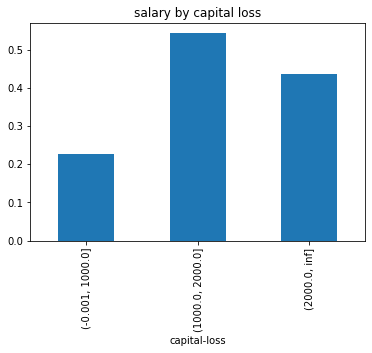

In [ ]:
df_code.groupby(closs_binned).salary.mean().plot.bar()
plt.title('salary by capital loss');

# Preprocessing

In [ ]:
# export

def scale_onehot(df, target):
    """Perform basic scaling and one-hot encoding"""
    
    features = df.drop(target, axis=1)
    
    categorical_cols = [[f] for f in features.select_dtypes('object').columns]
    categorical_pipe = gen_features(
        columns=categorical_cols, 
        classes=[{'class':SimpleImputer, 'strategy':'constant', 'fill_value':'Na'}, 
                 OneHotEncoder
                ])

    numerical_cols = [[f] for f in features.select_dtypes('number').columns]
    numerical_pipe = gen_features(
        columns=numerical_cols, 
        classes=[SimpleImputer, StandardScaler]
    )
    
    mapper = DataFrameMapper(categorical_pipe + numerical_pipe, df_out=True)
    
    X = mapper.fit_transform(df)
    
    y = df[target]
    
    target_names = sorted(y.unique())
    
    y = pd.Categorical(y, categories=target_names, ordered=True)
    y = y.codes
    
    return X, y, target_names

In [ ]:
X, y, target_names = scale_onehot(df, target='salary')

assert all([is_numeric_dtype(X[c]) for c in X.columns]), "Some column is not numeric"

assert X.shape[0] == df.shape[0], "Some rows lost in the preprocessing"

assert len(np.unique(y)) == 2

assert len(target_names) == len(np.unique(y))

/home/jupyterlab/ni-workspace/conda/envs/kd/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/home/jupyterlab/ni-workspace/conda/envs/kd/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/home/jupyterlab/ni-workspace/conda/envs/kd/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/home/jupyterlab/ni-workspace/conda/envs/kd/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_

# Preprocess with fastai.tabular

In [ ]:
df.dtypes

age                int64
workclass         object
fnlwgt             int64
education         object
education-num      int64
marital-status    object
occupation        object
relationship      object
race              object
sex               object
capital-gain       int64
capital-loss       int64
hours-per-week     int64
native-country    object
salary            object
dtype: object

In [ ]:
sorted(df.drop(columns=['salary']).select_dtypes('object').columns)


['education',
 'marital-status',
 'native-country',
 'occupation',
 'race',
 'relationship',
 'sex',
 'workclass']

In [ ]:
sorted(df.select_dtypes('int64').columns)


['age',
 'capital-gain',
 'capital-loss',
 'education-num',
 'fnlwgt',
 'hours-per-week']

In [ ]:
cont_names, cat_names = cont_cat_split(df.drop('salary', axis=1))

In [ ]:
assert len(df.columns) == 1 + len(cat_names + cont_names)

In [ ]:
procs = [Categorify, FillMissing, Normalize]

In [ ]:
tp = TabularPandas(df, 
              procs=procs, 
              cat_names=cat_names,
              cont_names=cont_names,
              y_names='salary'
             )

In [ ]:
df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,salary
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [ ]:
tp.ys[:5]

,salary
0,0
1,0
2,0
3,0
4,0


In [ ]:
tp.decode()
tp.ys[:5]

,salary
0,<=50K
1,<=50K
2,<=50K
3,<=50K
4,<=50K


In [ ]:
# export

def scale_fastai(df, target):
    """Perform scaling, fill missing and category codification, null_cols"""
    
    procs = [Categorify, FillMissing, Normalize]
    
    cont_names, cat_names = cont_cat_split(df.drop(target, axis=1))
    
    tp = TabularPandas(df, 
              procs=procs, 
              cat_names=cat_names,
              cont_names=cont_names,
              y_names=target
             )
    
    X_train, y_train = tp.train.xs, tp.train.ys.values.ravel()

    # Maybe this is wrong
    target_names = sorted(df[target].unique())
    
    return X_train, y_train, target_names

In [ ]:
X, y, target_names = scale_fastai(df, target='salary')

assert all([is_numeric_dtype(X[c]) for c in X.columns]), "Some column is not numeric"

assert X.shape[0] == df.shape[0], "Some rows lost in the preprocessing"

assert len(np.unique(y)) == 2

assert len(target_names) == len(np.unique(y))

assert_array_equal((df.salary == target_names[1]).astype(int), y, 'name mapping is incorrect')

# Reproducible splits

In [ ]:
# export

def split_with_seed(X, y, test_size=.2):
    X_train, X_test, y_train, y_test = train_test_split(
        X, 
        y, 
        test_size=test_size, 
        random_state=42)

    return X_train, X_test, y_train, y_test
    

In [ ]:
X_train, X_test, y_train, y_test = split_with_seed(X, y)

assert all([is_numeric_dtype(X_train[c]) for c in X_train.columns]), "Some column is not numeric"


assert X_train.shape[0] + X_test.shape[0] == df.shape[0], "Some rows haave been lost in the preprocessing"

assert len(np.unique(y_train)) == 2
assert len(np.unique(y_test)) == 2

# Dummy training (baseline)

In [ ]:
clf = DummyClassifier(strategy='most_frequent')

In [ ]:
clf.fit(X_train, y_train)

DummyClassifier(strategy='most_frequent')

# Evaluate

In [ ]:
# export

def evaluate_model(X_train, X_test, y_train, y_test, model, model_name, save_to_disk, print_report=True, target_names=None):
    y_train_pred = model.predict(X_train).astype(int)
    y_test_pred = model.predict(X_test).astype(int)
    
#     # if the y input is 2D (ie. one-hot encoded input), convert it to 1D
#     if y_train.ndim > 1:
#         y_train = np.nonzero(y_train)[1]
#         y_test = np.nonzero(y_test)[1]
        
#     elif y_train_pred.ndim > 1:
#         # if the y input is 2D (ie. one-hot encoded target), convert it to 1D
#         y_train_pred = np.nonzero(y_train_pred)[1]
#         y_test_pred = np.nonzero(y_test_pred)[1]
            
    preds = [(y_train, y_train_pred), (y_test, y_test_pred)]

    df = pd.DataFrame(
        dict(
            model_name = [model_name, model_name],
            data = ['train', 'test'],
            accuracy = [accuracy_score(y_true, y_pred) for y_true, y_pred in preds],
            precision = [precision_score(y_true, y_pred) for y_true, y_pred in preds],
            recall = [recall_score(y_true, y_pred) for y_true, y_pred in preds],
            f1 = [f1_score(y_true, y_pred) for y_true, y_pred in preds],
            auc = [roc_auc_score(y_true, y_pred) for y_true, y_pred in preds],
        )
    )
    
    df.to_csv(ASSETS_PATH / f"{model_name}_evaluation.csv", index=False)
    if print_report:
        print("=== Train ===")
        print(classification_report(*preds[0], labels=[0, 1], target_names=target_names))
        print("\n=== Test ===")
        print(classification_report(*preds[1], labels=[0, 1], target_names=target_names))
        print()
    
    return df

In [ ]:
evaluate_model(X_train, X_test, y_train, y_test, clf, 'dummy', save_to_disk=True, target_names=target_names)

=== Train ===
              precision    recall  f1-score   support

       <=50K       0.76      1.00      0.86     19778
        >50K       0.00      0.00      0.00      6270

    accuracy                           0.76     26048
   macro avg       0.38      0.50      0.43     26048
weighted avg       0.58      0.76      0.66     26048


=== Test ===
              precision    recall  f1-score   support

       <=50K       0.76      1.00      0.86      4942
        >50K       0.00      0.00      0.00      1571

    accuracy                           0.76      6513
   macro avg       0.38      0.50      0.43      6513
weighted avg       0.58      0.76      0.65      6513




/home/jupyterlab/ni-workspace/conda/envs/kd/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jupyterlab/ni-workspace/conda/envs/kd/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jupyterlab/ni-workspace/conda/envs/kd/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jupy

,model_name,data,accuracy,precision,recall,f1,auc
0,dummy,train,0.759291,0.0,0.0,0.0,0.5
1,dummy,test,0.758790,0.0,0.0,0.0,0.5


# Ensemble identical models with different random seed and average

In [ ]:
# LR with random state 1..10
estimators = [(f'dummy_{x}', DummyClassifier(random_state=x)) for x in range(1, 11)]

stack = StackingClassifier(
    estimators, 
    final_estimator=UnbiasedAverage(), 
    n_jobs=-1)

stack.fit(X_train, y_train)

StackingClassifier(estimators=[('dummy_1', DummyClassifier(random_state=1)),
                               ('dummy_2', DummyClassifier(random_state=2)),
                               ('dummy_3', DummyClassifier(random_state=3)),
                               ('dummy_4', DummyClassifier(random_state=4)),
                               ('dummy_5', DummyClassifier(random_state=5)),
                               ('dummy_6', DummyClassifier(random_state=6)),
                               ('dummy_7', DummyClassifier(random_state=7)),
                               ('dummy_8', DummyClassifier(random_state=8)),
                               ('dummy_9', DummyClassifier(random_state=9)),
                               ('dummy_10', DummyClassifier(random_state=10))],
                   final_estimator=UnbiasedAverage(), n_jobs=-1)

In [ ]:
evaluate_model(X_train, X_test, y_train, y_test, stack, 'dummy_ensemble', save_to_disk=True, target_names=target_names)

=== Train ===
              precision    recall  f1-score   support

       <=50K       0.76      1.00      0.86     19778
        >50K       0.00      0.00      0.00      6270

    accuracy                           0.76     26048
   macro avg       0.38      0.50      0.43     26048
weighted avg       0.58      0.76      0.66     26048


=== Test ===
              precision    recall  f1-score   support

       <=50K       0.76      1.00      0.86      4942
        >50K       0.00      0.00      0.00      1571

    accuracy                           0.76      6513
   macro avg       0.38      0.50      0.43      6513
weighted avg       0.58      0.76      0.65      6513




/home/jupyterlab/ni-workspace/conda/envs/kd/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jupyterlab/ni-workspace/conda/envs/kd/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jupyterlab/ni-workspace/conda/envs/kd/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jupy

,model_name,data,accuracy,precision,recall,f1,auc
0,dummy_ensemble,train,0.759291,0.0,0.0,0.0,0.5
1,dummy_ensemble,test,0.758790,0.0,0.0,0.0,0.5


# Export module

In [ ]:
from nbdev.export import notebook2script
notebook2script()

Converted 00_io.ipynb.
Converted 01_processing.ipynb.
Converted 02_ensemble.ipynb.
Converted 03a_logistic.ipynb.
Converted 03b_NN.ipynb.
Converted 03c_bag_of_trees.ipynb.
Converted 04_train_NN.ipynb.
Converted 05_train_multiple_NNs.ipynb.
Converted 05a_test_seed_is_working.ipynb.
Converted 06_NN_ensemble.ipynb.
Converted 07_distill_multiple_NNs.ipynb.
Converted 07a_train_and_distill_multiple_NNs.ipynb.
Converted 08_compare.ipynb.
Converted index.ipynb.
